In [143]:
import os
import utils
import dotenv
import umap
import pandas as pd
import numpy as np
import dataextraction as db
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans, Birch
import hdbscan

In [99]:
# Loads the environment variables from the .env file
dotenv.load_dotenv()

True

In [100]:
# Connect to database
conn = db.connect_to_database()
cur = conn.cursor()
df = db.get_base_dataset(conn)

Connected to the PostgreSQL database
PostgreSQL version: PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit


In [101]:
# Number of duplicate subjects
df['subject_id'].duplicated().sum()

11976

In [102]:
# Get only first ICU admissions
df = df[df['first_icu_stay'] == True]

In [103]:
# Check duplicate subject_id's again
df['subject_id'].duplicated().sum()

9321

In [104]:
# Aggregate missing mean columns by taking average of minimum and maximum
missing_mean_columns = utils.detect_missing_mean_columns(df)
df = utils.add_missing_mean_columns(df, missing_mean_columns)

In [105]:
# Then aggregate rest of the mean columns by taking average of the subject_id's multiple mean values
mean_columns = [col for col in df.columns if '_mean' in col]
aggregation_functions = {}
for col in mean_columns:
    aggregation_functions[col] = 'mean'
aggregation_functions

{'heartrate_mean': 'mean',
 'sysbp_mean': 'mean',
 'diasbp_mean': 'mean',
 'meanbp_mean': 'mean',
 'resprate_mean': 'mean',
 'tempc_mean': 'mean',
 'spo2_mean': 'mean',
 'glucose_mean': 'mean',
 'aniongap_mean': 'mean',
 'albumin_mean': 'mean',
 'bands_mean': 'mean',
 'bicarbonate_mean': 'mean',
 'bilirubin_mean': 'mean',
 'creatinine_mean': 'mean',
 'chloride_mean': 'mean',
 'hematocrit_mean': 'mean',
 'hemoglobin_mean': 'mean',
 'lactate_mean': 'mean',
 'platelet_mean': 'mean',
 'potassium_mean': 'mean',
 'ptt_mean': 'mean',
 'inr_mean': 'mean',
 'pt_mean': 'mean',
 'sodium_mean': 'mean',
 'bun_mean': 'mean',
 'wbc_mean': 'mean'}

In [106]:
# Aggregated dataframe for later merging it with the original dataframe
df_aggregated = df.groupby('subject_id').agg(aggregation_functions).reset_index()

In [107]:
# Printing out the aggregated dataframe
df_aggregated

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,hemoglobin_mean,lactate_mean,platelet_mean,potassium_mean,ptt_mean,inr_mean,pt_mean,sodium_mean,bun_mean,wbc_mean
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.0,...,10.30,5.45,274.5,4.55,44.5,1.50,14.60,144.5,47.0,17.85
1,4,89.217391,118.000000,69.000000,85.333321,25.352941,36.844445,97.500000,199.666667,15.0,...,10.55,2.10,201.0,3.30,33.2,1.10,12.80,141.0,10.0,9.70
2,6,84.160000,153.647059,56.558824,84.539218,12.320000,36.515152,99.200000,148.500000,21.5,...,9.50,NaN,322.5,5.10,89.8,1.20,13.60,136.0,63.5,10.60
3,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.0,...,14.15,2.30,253.5,2.90,21.7,1.10,12.70,138.0,16.5,10.60
4,11,84.958333,105.166667,52.541667,71.416667,18.045455,36.805556,96.500000,129.875000,14.0,...,12.55,NaN,250.5,3.85,NaN,NaN,NaN,141.5,16.5,11.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37810,99985,88.846154,114.600000,59.840000,76.280000,21.312500,37.759259,96.538462,106.500000,11.5,...,9.55,1.65,251.5,3.90,47.7,1.10,12.50,135.0,14.5,12.45
37811,99991,104.333333,166.306122,82.428571,110.940000,26.266667,37.090278,97.000000,139.500000,11.0,...,9.70,1.15,230.5,3.80,27.8,1.00,12.10,144.5,22.0,5.75
37812,99992,68.521739,124.318182,51.818182,69.363636,15.695652,36.416667,92.739130,118.000000,14.5,...,7.85,NaN,146.5,4.75,43.9,1.10,12.90,136.0,56.0,19.25
37813,99995,69.935484,134.433333,50.333333,79.266667,20.228571,37.000000,98.000000,122.285714,8.5,...,8.75,1.20,177.5,3.60,31.7,1.65,17.55,135.5,11.5,7.75


In [108]:
# Number of duplicate subject_id's in aggregated dataframe
df_aggregated.duplicated().sum()

0

In [109]:
# Merging the aggregated dataframe with the original dataframe on subject_id by excluding minimum and maximum and mean columns since
# df_aggregated includes unique subject_id's mean (aggregated measurements)
other_columns = [col for col in df.columns if('_mean' not in col and '_min' not in col and '_max' not in col)]
other_columns

['hadm_id',
 'subject_id',
 'first_wardid',
 'last_wardid',
 'intime',
 'outtime',
 'los',
 'icustay_id',
 'dod',
 'los_hospital',
 'admission_age',
 'hospital_expire_flag',
 'hospstay_seq',
 'first_hosp_stay',
 'los_icu',
 'icustay_seq',
 'first_icu_stay',
 'row_id',
 'admittime',
 'dischtime',
 'deathtime',
 'edregtime',
 'edouttime',
 'has_chartevents_data',
 'gender',
 'insurance',
 'language',
 'religion',
 'marital_status',
 'ethnicity_grouped',
 'diagnosis',
 'ethnicity',
 'dbsource',
 'first_careunit',
 'last_careunit',
 'admission_type',
 'admission_location',
 'discharge_location',
 'mingcs',
 'gcsmotor',
 'gcsverbal',
 'gcseyes',
 'endotrachflag',
 'height',
 'height_chart',
 'height_echo',
 'urineoutput',
 'vent',
 'weight',
 'weight_admit',
 'weight_daily',
 'weight_echoinhosp',
 'weight_echoprehosp',
 'rrt']

In [110]:
# Grouping by subject_id and taking the first value of each column
df_other_columns = df.groupby('subject_id', as_index=False)[other_columns].first()

In [111]:
# Merging it with the rest of the dataframe on subject_id (since we grouped by first we only left with unique
# subject_id's measurements with respect to df_aggregated)
df = pd.merge(df_aggregated, df_other_columns, on='subject_id')

In [112]:
# Checking out duplicate subject_id's to make sure we have unique subject_id's
df['subject_id'].duplicated().sum()

0

In [113]:
# Check out glucose_mean column to see if it is aggregated correctly
df['glucose_mean']

0        232.416667
1        199.666667
2        148.500000
3        161.285714
4        129.875000
            ...    
37810    106.500000
37811    139.500000
37812    118.000000
37813    122.285714
37814    142.666667
Name: glucose_mean, Length: 37815, dtype: float64

In [114]:
# Printing out the record of subject id that equals to 3 \
df[df["subject_id"] == 3]

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,height_chart,height_echo,urineoutput,vent,weight,weight_admit,weight_daily,weight_echoinhosp,weight_echoprehosp,rrt
0,3,111.785714,102.96,55.72,75.692812,17.361111,37.002881,97.870968,232.416667,19.0,...,179.07,None,497.0,1,96.8,96.800003,101.400002,None,None,0


In [115]:
# Focusing on column types for possible encoding of the categorical columns and possible
# columns that could be removed because it is irrelevant to the prediction
df.dtypes

subject_id              int64
heartrate_mean        float64
sysbp_mean            float64
diasbp_mean           float64
meanbp_mean           float64
                       ...   
weight_admit          float64
weight_daily          float64
weight_echoinhosp      object
weight_echoprehosp     object
rrt                     int64
Length: 80, dtype: object

In [116]:
# Detecting the datetime columns
for key, val in df.dtypes.to_dict().items():
    if('date' in str(val)):
        print(key, val)

intime datetime64[ns]
outtime datetime64[ns]
dod datetime64[ns]
admittime datetime64[ns]
dischtime datetime64[ns]
deathtime datetime64[ns]
edregtime datetime64[ns]
edouttime datetime64[ns]


In [117]:
# Dropping the detected datetime columns
columns_to_remove = ['intime', 'outtime', 'dod', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime']
df = df.drop(columns_to_remove, axis=1)

In [118]:
# Checking out the dataframe size if the columns are dropped correctly
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,height_chart,height_echo,urineoutput,vent,weight,weight_admit,weight_daily,weight_echoinhosp,weight_echoprehosp,rrt
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.0,...,179.07,None,497.0,1,96.8,96.800003,101.400002,None,None,0
1,4,89.217391,118.000000,69.000000,85.333321,25.352941,36.844445,97.500000,199.666667,15.0,...,NaN,None,2150.0,0,53.6,NaN,53.599998,None,None,0
2,6,84.160000,153.647059,56.558824,84.539218,12.320000,36.515152,99.200000,148.500000,21.5,...,NaN,None,1940.0,0,NaN,NaN,NaN,None,None,0
3,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.0,...,182.88,None,887.0,1,104.0,104.000000,104.000000,None,None,0
4,11,84.958333,105.166667,52.541667,71.416667,18.045455,36.805556,96.500000,129.875000,14.0,...,NaN,None,1050.0,0,NaN,NaN,NaN,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37810,99985,88.846154,114.600000,59.840000,76.280000,21.312500,37.759259,96.538462,106.500000,11.5,...,NaN,None,1150.0,1,NaN,NaN,NaN,None,None,0
37811,99991,104.333333,166.306122,82.428571,110.940000,26.266667,37.090278,97.000000,139.500000,11.0,...,NaN,None,4330.0,0,100.5,100.500000,NaN,None,None,0
37812,99992,68.521739,124.318182,51.818182,69.363636,15.695652,36.416667,92.739130,118.000000,14.5,...,NaN,None,1570.0,0,65.4,65.400000,NaN,None,None,0
37813,99995,69.935484,134.433333,50.333333,79.266667,20.228571,37.000000,98.000000,122.285714,8.5,...,159.00,None,1495.0,1,68.0,68.000000,NaN,None,None,0


In [119]:
# Detecting columns with the null values that is above 90% of the total dataframe size
columns_to_remove = []
for key, value in df.isnull().sum().to_dict().items():
    if(((value / df.shape[0]) * 100) > 50):
        print(key, value)
        columns_to_remove.append(key)

albumin_mean 22889
bands_mean 32696
bilirubin_mean 20009
height 20653
height_chart 20653
height_echo 37815
weight_echoinhosp 37815
weight_echoprehosp 37815


In [120]:
# Dropping the detected columns with the null values that is above 90% of the total dataframe size
df = df.drop(columns_to_remove, axis=1)

In [121]:
# Checking out dataframe size if the columns are dropped correctly
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,gcsmotor,gcsverbal,gcseyes,endotrachflag,urineoutput,vent,weight,weight_admit,weight_daily,rrt
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.0,...,1.0,0.0,1.0,1.0,497.0,1,96.8,96.800003,101.400002,0
1,4,89.217391,118.000000,69.000000,85.333321,25.352941,36.844445,97.500000,199.666667,15.0,...,6.0,5.0,4.0,0.0,2150.0,0,53.6,NaN,53.599998,0
2,6,84.160000,153.647059,56.558824,84.539218,12.320000,36.515152,99.200000,148.500000,21.5,...,6.0,5.0,4.0,0.0,1940.0,0,NaN,NaN,NaN,0
3,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.0,...,5.0,0.0,1.0,1.0,887.0,1,104.0,104.000000,104.000000,0
4,11,84.958333,105.166667,52.541667,71.416667,18.045455,36.805556,96.500000,129.875000,14.0,...,5.0,4.0,4.0,0.0,1050.0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37810,99985,88.846154,114.600000,59.840000,76.280000,21.312500,37.759259,96.538462,106.500000,11.5,...,6.0,5.0,4.0,0.0,1150.0,1,NaN,NaN,NaN,0
37811,99991,104.333333,166.306122,82.428571,110.940000,26.266667,37.090278,97.000000,139.500000,11.0,...,6.0,5.0,3.0,0.0,4330.0,0,100.5,100.500000,NaN,0
37812,99992,68.521739,124.318182,51.818182,69.363636,15.695652,36.416667,92.739130,118.000000,14.5,...,6.0,5.0,4.0,0.0,1570.0,0,65.4,65.400000,NaN,0
37813,99995,69.935484,134.433333,50.333333,79.266667,20.228571,37.000000,98.000000,122.285714,8.5,...,6.0,0.0,3.0,1.0,1495.0,1,68.0,68.000000,NaN,0


In [122]:
# Detecting the categorical columns 
for key, val in df.dtypes.to_dict().items():
    if('object' in str(val)):
        print(key, val)

gender object
insurance object
language object
religion object
marital_status object
ethnicity_grouped object
diagnosis object
ethnicity object
dbsource object
first_careunit object
last_careunit object
admission_type object
admission_location object
discharge_location object


In [123]:
# Binary encoding the gender columns
df['gender'] = df['gender'].map({'M': 0, 'F': 1})
df['gender']

0        0
1        1
2        1
3        0
4        1
        ..
37810    0
37811    0
37812    1
37813    1
37814    1
Name: gender, Length: 37815, dtype: int64

In [124]:
# Frequency mapping diagnosis column since it has too many unique values
frequency_mapping = df['diagnosis'].value_counts(normalize=True)
df['diagnosis_encoded'] = df['diagnosis'].map(frequency_mapping)
df['diagnosis_encoded']

0        0.006717
1        0.000026
2        0.000476
3        0.000053
4        0.002724
           ...   
37810    0.007828
37811    0.000423
37812    0.000053
37813    0.001904
37814    0.000026
Name: diagnosis_encoded, Length: 37815, dtype: float64

In [125]:
# For rest of the cateogircal columns we will use one hot encoding
categorical_cols = ['marital_status', 'ethnicity_grouped',
                    'first_careunit', 'last_careunit', 'admission_type',
                    'admission_location', 'discharge_location', 'insurance']
df = pd.get_dummies(df, columns=categorical_cols)

In [126]:
# Dropping rest of the unecessary columns 
columns_to_remove = ['language', 'religion', 'diagnosis', 'ethnicity', 'dbsource']
df = df.drop(columns_to_remove, axis=1)

In [127]:
for key, val in df.dtypes.to_dict().items():
    if('object' in str(val)):
        print(key, val)

In [128]:
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.0,...,False,False,False,True,False,False,False,True,False,False
1,4,89.217391,118.000000,69.000000,85.333321,25.352941,36.844445,97.500000,199.666667,15.0,...,False,False,False,False,False,False,False,False,True,False
2,6,84.160000,153.647059,56.558824,84.539218,12.320000,36.515152,99.200000,148.500000,21.5,...,False,False,False,False,False,False,False,True,False,False
3,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.0,...,False,False,False,False,False,False,True,False,False,False
4,11,84.958333,105.166667,52.541667,71.416667,18.045455,36.805556,96.500000,129.875000,14.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37810,99985,88.846154,114.600000,59.840000,76.280000,21.312500,37.759259,96.538462,106.500000,11.5,...,False,False,False,False,False,False,False,False,True,False
37811,99991,104.333333,166.306122,82.428571,110.940000,26.266667,37.090278,97.000000,139.500000,11.0,...,False,False,False,False,False,False,False,False,True,False
37812,99992,68.521739,124.318182,51.818182,69.363636,15.695652,36.416667,92.739130,118.000000,14.5,...,False,False,False,True,False,False,False,True,False,False
37813,99995,69.935484,134.433333,50.333333,79.266667,20.228571,37.000000,98.000000,122.285714,8.5,...,False,False,False,False,False,False,False,True,False,False


In [129]:
# Saving dataset for use in eda later on
# df.to_csv(f'{os.getenv("ROOT_DIR")}\\data\\final.csv', index=False)

In [130]:
# Detecting columns with the null values that is above 90% of the total dataframe size
for key, value in df.isnull().sum().to_dict().items():   
        print(key, value)

subject_id 0
heartrate_mean 2
sysbp_mean 30
diasbp_mean 31
meanbp_mean 4
resprate_mean 42
tempc_mean 608
spo2_mean 26
glucose_mean 596
aniongap_mean 1022
bicarbonate_mean 454
creatinine_mean 213
chloride_mean 309
hematocrit_mean 201
hemoglobin_mean 279
lactate_mean 14256
platelet_mean 324
potassium_mean 171
ptt_mean 3536
inr_mean 3461
pt_mean 3465
sodium_mean 214
bun_mean 219
wbc_mean 396
hadm_id 0
first_wardid 0
last_wardid 0
los 0
icustay_id 0
los_hospital 0
admission_age 0
hospital_expire_flag 0
hospstay_seq 0
first_hosp_stay 0
los_icu 0
icustay_seq 0
first_icu_stay 0
row_id 0
has_chartevents_data 0
gender 0
mingcs 52
gcsmotor 301
gcsverbal 265
gcseyes 148
endotrachflag 52
urineoutput 53
vent 0
weight 3952
weight_admit 7326
weight_daily 17616
rrt 0
diagnosis_encoded 1
marital_status_DIVORCED 0
marital_status_LIFE PARTNER 0
marital_status_MARRIED 0
marital_status_SEPARATED 0
marital_status_SINGLE 0
marital_status_UNKNOWN (DEFAULT) 0
marital_status_WIDOWED 0
ethnicity_grouped_asian 0


In [131]:
df = df.dropna()
df

,subject_id,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,aniongap_mean,...,discharge_location_OTHER FACILITY,discharge_location_REHAB/DISTINCT PART HOSP,discharge_location_SHORT TERM HOSPITAL,discharge_location_SNF,discharge_location_SNF-MEDICAID ONLY CERTIF,insurance_Government,insurance_Medicaid,insurance_Medicare,insurance_Private,insurance_Self Pay
0,3,111.785714,102.960000,55.720000,75.692812,17.361111,37.002881,97.870968,232.416667,19.000000,...,False,False,False,True,False,False,False,True,False,False
3,9,92.500000,159.375000,79.525000,98.850000,14.369565,37.049383,97.650000,161.285714,13.000000,...,False,False,False,False,False,False,True,False,False,False
11,21,71.385714,101.817016,44.110723,65.891024,16.838690,36.796465,98.057598,160.000000,21.000000,...,False,False,False,False,False,False,False,True,False,False
15,25,72.906250,100.000000,46.583333,63.324330,16.031250,36.333333,97.096774,164.766667,13.000000,...,False,False,False,False,False,False,False,False,True,False
19,31,51.230769,114.153846,59.923077,79.923077,12.066667,36.958333,98.714286,108.142857,9.500000,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37791,99913,93.676471,117.111111,51.166667,69.194444,18.200000,36.936000,98.562500,129.434783,11.500000,...,False,False,False,False,False,False,False,True,False,False
37792,99922,86.185185,111.068966,55.206897,69.206897,15.678571,36.555128,97.592593,124.684211,11.000000,...,False,False,False,False,False,False,False,True,False,False
37793,99923,95.006944,106.881558,59.216216,72.278219,15.500000,36.516204,97.685484,130.333333,15.000000,...,False,False,False,False,False,False,False,False,True,False
37801,99944,74.461538,130.730769,53.923077,72.769231,22.600000,36.111111,94.423077,138.000000,17.000000,...,False,False,False,True,False,False,False,True,False,False


In [132]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [133]:
pca = PCA(n_components=20)
pca_result = pca.fit_transform(scaled_data)

In [134]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

In [135]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(pca_result)

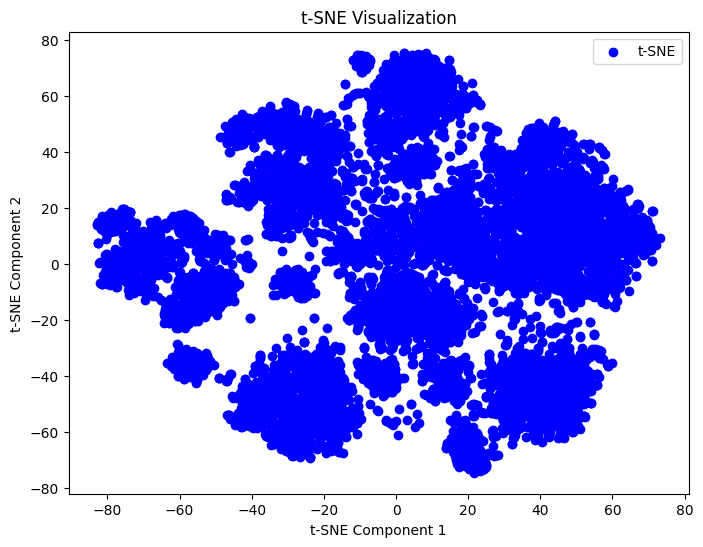

In [136]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='b', marker='o', label='t-SNE')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


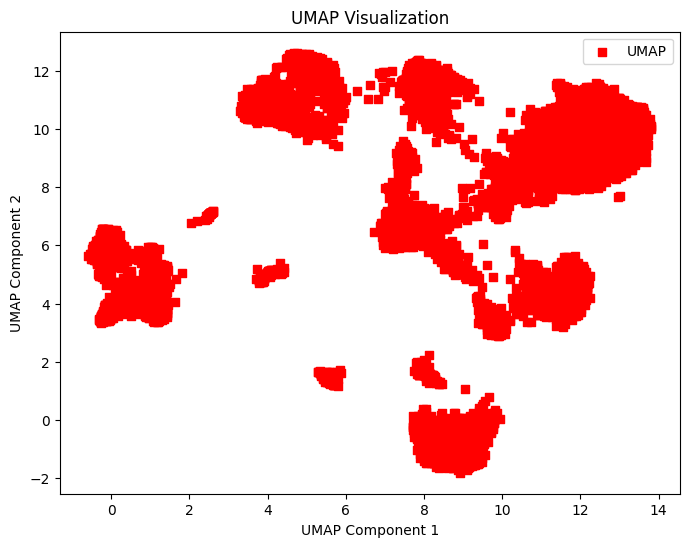

In [137]:
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='r', marker='s', label='UMAP')
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()

C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\3036754217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GMM_Cluster_UMAP'] = gmm_labels


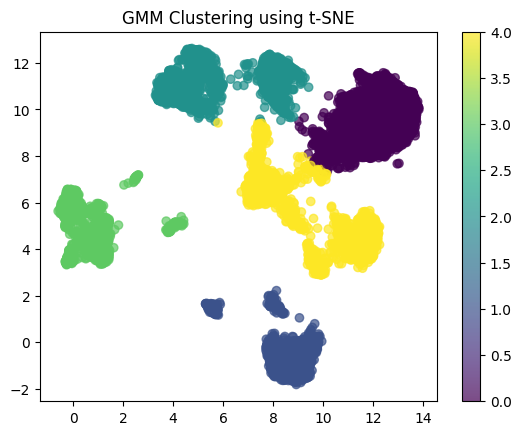

In [138]:
n_clusters = 5

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(umap_result)

df['GMM_Cluster_UMAP'] = gmm_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('GMM Clustering using t-SNE')
plt.show()

C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\129167812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DBSCAN_Cluster'] = dbscan_labels


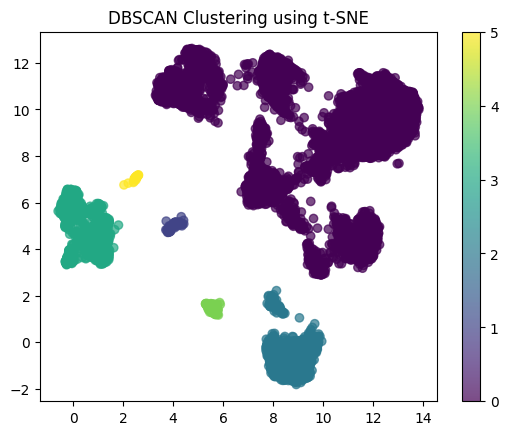

In [139]:
eps = 0.8
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(umap_result)

df['DBSCAN_Cluster'] = dbscan_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('DBSCAN Clustering using t-SNE')
plt.show()

C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\2092425413.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HDBSCAN_Cluster'] = hdb_labels


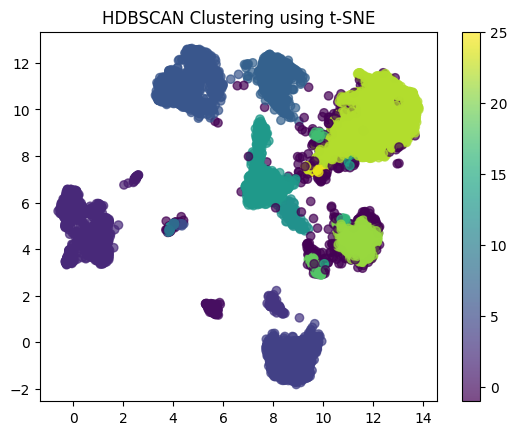

In [140]:
min_cluster_size = 5

hdb = hdbscan.HDBSCAN(min_samples=min_cluster_size)
hdb_labels = hdb.fit_predict(umap_result)

df['HDBSCAN_Cluster'] = hdb_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hdb_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('HDBSCAN Clustering using t-SNE')
plt.show()

C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\1743015126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spectral_Cluster'] = spectral_labels


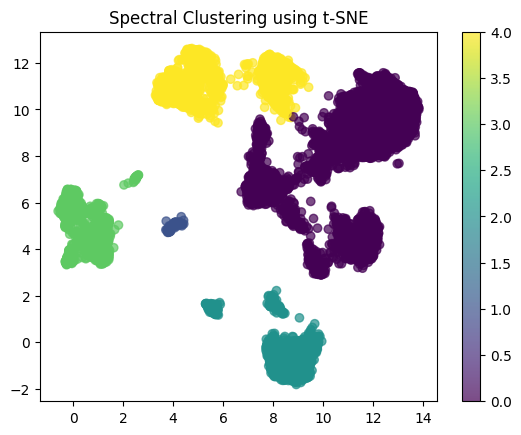

In [141]:
n_clusters = 5

spectral_clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', random_state=42)
spectral_labels = spectral_clustering.fit_predict(umap_result)

df['Spectral_Cluster'] = spectral_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Spectral Clustering using t-SNE')
plt.show()

C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\2426455721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Birch_Cluster'] = birch_labels


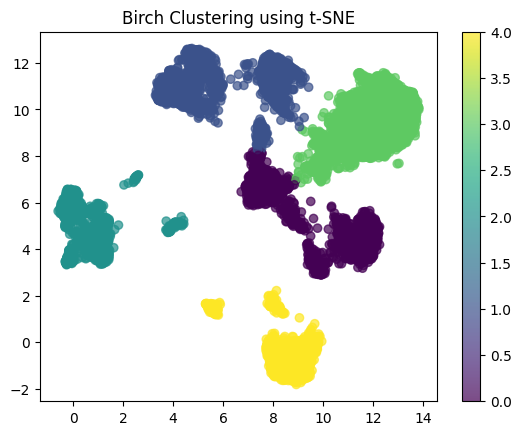

In [145]:
n_clusters = 5

birch = Birch(n_clusters=n_clusters)
birch_labels = birch.fit_predict(umap_result)

df['Birch_Cluster'] = birch_labels

# Plotting the Birch clusters in 2D (assuming tsne_result, you can use umap_result as well)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=birch_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('Birch Clustering using t-SNE')
plt.show()

d:\workspace\github\icu-flow-prediction\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\hakve\AppData\Local\Temp\ipykernel_13664\3793112523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['KMeans_Cluster'] = kmeans_labels


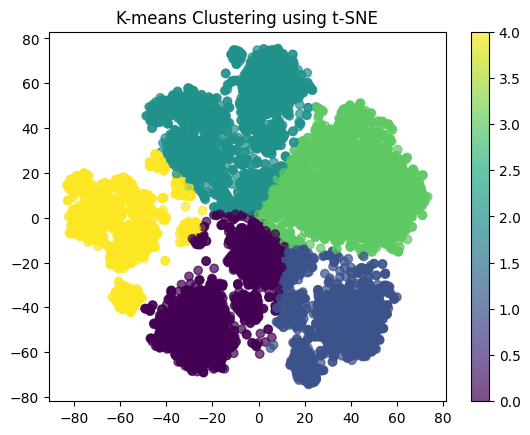

In [146]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_result)

df['KMeans_Cluster'] = kmeans_labels

plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('K-means Clustering using t-SNE')
plt.show()